Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.



# Предсказание стоимости автомобилей

## <a id ='start'>Содержание</a>

### [Подготовка данных](#preprocessing)

* [Первый взгляд](#first)

* [Сокращение признаков](#useless)

* [Заполнение пропусков](#fillna)

* [Основная предобработка](#useless)

### [Обучение моделей](#learning)

* [Делаем пайплайны](#pipelines)


### [Анализ моделей](#analysis)

* [Подбор гиперпараметров для бустинга](#learning_f)

* [Последние измерения](#final_measure)

* [Выводы](#summary)

<div class="alert alert-block alert-success">
    
<b>Комментарий ревьюера v2:</b>    
Отлично! ~~Только последние 2 ссылки не работают, исправь это, пожалуйста.~~
</div>


# <a id='preprocessing'>1. Подготовка данных</a>


In [1]:
!pip install pandas_profiling

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 258 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 414 kB/s eta 0:00:01
     |████████████████████████████████| 64 kB 3.5 MB/s  eta 0:00:01
     |████████████████████████████████| 49 kB 3.8 MB/s  eta 0:00:01
     |████████████████████████████████| 599 kB 44.8 MB/s eta 0:00:01
     |████████████████████████████████| 283 kB 29.0 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 3.0 MB/s  eta 0:00:01
     |████████████████████████████████| 61 kB 6.9 MB/s  eta 0:00:01
     |████████████████████████████████| 121 kB 34.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 29.8 MB/s eta 0:00:01
     |████████████████████████████████| 291 kB 30.4 MB/s eta 0:00:01
     |█████████████████████████

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from tqdm import tqdm

In [3]:
df = pd.read_csv(PATH, parse_dates=True)

### <a id ="first">Получим предварительноe описание данных с помощью профайлера </a>

In [4]:
profile = ProfileReport(df, title='Autos Profiling Report', explorative=True)

In [5]:
profile.to_notebook_iframe()

По отчету набора данных мы можем сделать несколько выводов:


1) Есть большое количество объектов с пропущенными значениями в столбцах. Соответственно, мы должны как минимум избавиться от пропусков в целевом признаке

2) Столбцы `DateCrawled`, `DateCreated`, `LastSeen` мета-информация, которая не будет использовать сервисом в поступающим данным. Та же ситуация со столбцом `NumberOfPictures` (будет вводиться текстовое описание клиента), `PostalCode` также вряд ли можно будет применить без справочника местоположения (Хотя можно провести эксперимент с выдергиванием первых чисел)

3) У нас есть достаточное количество категориальных фич, которые требуют перекодировки. Причем скорее всего будет необходимо избрать различные стратегии перекодирования, чтобы избежать сложностей в обучении любой из моделей.

4) Уникальных значений бренда автомобиля - 40, моделей - 250 (вряд ли мы можем позволить себе кодировать такое количество брендов)

5) Мы помним, что есть модели с нулевым значением цены, от таких можно избавиться. 

6) Также можно избавиться от строчек с нерелевантной датой регистрации (такие тоже есть по отчету)

**Таким образом, наши фичи:**

1) VehicleType (LabelEncoding)

2) RegistrationYear (ограничимся им)

3) Gearbox (OneHotEncoding)

4) Power (Scaler)

5) Brand (LabelEncoding???)

6) Kilometer (Scaler)

7) FuelType (OneHotEncoding)

8) NotRepaired (Bool)

9) Target - Price

### Можно ли однозначно определить населенный пункт по почтовому индексу без справочника?




Если можно сократить его размерность до нескольких числовых значений к

In [6]:
print(sorted(df['PostalCode'].unique())[100:200])

[2689, 2692, 2694, 2699, 2708, 2727, 2730, 2733, 2736, 2739, 2742, 2747, 2748, 2763, 2779, 2782, 2785, 2788, 2791, 2794, 2796, 2797, 2799, 2826, 2827, 2828, 2829, 2894, 2899, 2906, 2923, 2929, 2943, 2953, 2956, 2957, 2959, 2977, 2979, 2991, 2994, 2997, 2999, 3042, 3044, 3046, 3048, 3050, 3051, 3053, 3054, 3055, 3058, 3096, 3099, 3103, 3116, 3119, 3130, 3149, 3159, 3172, 3185, 3197, 3205, 3222, 3226, 3229, 3238, 3246, 3249, 3253, 4103, 4105, 4107, 4109, 4129, 4155, 4157, 4158, 4159, 4177, 4178, 4179, 4205, 4207, 4209, 4229, 4249, 4275, 4277, 4279, 4288, 4289, 4299, 4315, 4316, 4317, 4318, 4319]


***Стратегия с первыми 3-мя цифрами себя бы не оправдала, так как индексы слишком различаются между собой и сложно было бы их сопоставить с конкретным населенным пунктом и векторизовать (Большой город, средний город, маленький, деревня и т.д.)***



Признак категориальный и отображает местоположение в рамках одной страны - предположительно Германии. Если это Германия - то маленькие индексы - это южные регионы, другие - по возрастанию на север "земель"

Цена зависит от покупательской способности на рынке региона. Соответственно, Postal code ***отображает территориальное рассеяние*** объявления. 

Таким образом, он является дополнительным фактором для формирования Price. Модели бустинга/деревьев будут сами выбирать его значимость.

По пандас профайлеру средние значения (3000-4000) имеют максимальную частоту.


### <a id ="useless">Уберем ненужные столбцы</a>


In [7]:
cols_to_drop = ['DateCrawled','DateCreated','LastSeen','RegistrationMonth','NumberOfPictures', 'PostalCode']

df = df.drop(cols_to_drop, axis=1)


### <a id ="extreme"> Уберем экстремальные значения в числовых features</a>

In [9]:
num_cols = ['RegistrationYear','Price','Power','Kilometer']

df[num_cols].describe()

RegistrationYear          Price          Power      Kilometer
count     354369.000000  354369.000000  354369.000000  354369.000000
mean        2004.234448    4416.656776     110.094337  128211.172535
std           90.227958    4514.158514     189.850405   37905.341530
min         1000.000000       0.000000       0.000000    5000.000000
25%         1999.000000    1050.000000      69.000000  125000.000000
50%         2003.000000    2700.000000     105.000000  150000.000000
75%         2008.000000    6400.000000     143.000000  150000.000000
max         9999.000000   20000.000000   20000.000000  150000.000000

**Требуется исправить фичеры года регистрации, цены, мощности**

***Отбор с помощью подбора по перцентилям***

In [10]:
lower_price  = np.percentile(np.array(df['Price']), 4)
high_price = np.percentile(np.array(df['Price']), 100)

print(f'Нижняя граница цены в 4% - {lower_price}\n\
Верхняя граница цены в 100% - {high_price}')

Нижняя граница цены в 4% - 100.0
Верхняя граница цены в 100% - 20000.0


In [11]:
lower_year  = np.percentile(np.array(df['RegistrationYear']), 1.0)
high_year = np.percentile(np.array(df['RegistrationYear']), 97.5)

print(f'Нижняя граница года в 1% - {lower_year}\n\
Верхняя граница года в 97.5% - {high_year}')

Нижняя граница года в 1% - 1980.0
Верхняя граница года в 97.5% - 2017.0


In [12]:
lower_power = np.percentile(np.array(df['Power']), 12.5)
high_power = np.percentile(np.array(df['Power']), 99.5)

print(f'Нижняя граница мощности в 12,5% - {lower_power}\n\
Верхняя граница мощности в 97.5% - {high_power}')


Нижняя граница мощности в 12,5% - 45.0
Верхняя граница мощности в 97.5% - 334.0


In [13]:
bad_ids = df[(df['Price'] < lower_price) | (df['RegistrationYear'] > high_year) |\
             (df['RegistrationYear'] < lower_year) |\
            (df['Power'] < lower_power) | (df['Power'] > high_power)].index

len(bad_ids)

57267

In [14]:
df = df.drop(bad_ids)

In [15]:
df[['Price', 'RegistrationYear','Power']].describe()

Price  RegistrationYear          Power
count  297102.000000     297102.000000  297102.000000
mean     4800.753812       2003.445557     120.014796
std      4554.138120          6.190362      50.308079
min       100.000000       1980.000000      45.000000
25%      1350.000000       1999.000000      78.000000
50%      3100.000000       2003.000000     111.000000
75%      6900.000000       2008.000000     150.000000
max     20000.000000       2017.000000     334.000000

In [16]:
df.shape

(297102, 10)

### Проверим сколько данных мы потеряем если дропнем все значения

In [17]:
df.isnull().sum()

Price                   0
VehicleType         17858
RegistrationYear        0
Gearbox              5461
Power                   0
Model               11087
Kilometer               0
FuelType            17833
Brand                   0
NotRepaired         44435
dtype: int64

In [18]:
nan_all = len(df.dropna())

print(f'Потери из-за nan: {df.shape[0] - nan_all}\n\
Общий объем: {len(df)}')

Потери из-за nan: 67988
Общий объем: 297102


Это слишком большой объем потерь из исходного набора данных, значит мы должны выбрать стратегию заполнения пропущенных значений.


## <a id ="fillna">Заполнение пропущенных значений</a>

1) Попробуем заполнить пропущенные значения по моде конфигурации - соответствие параметров модели - она будет уникальной в большинстве случаев

2) Ещё раз проверим количество пропусков и уберем оставшиеся NaN

In [19]:
def fill_cat_nan(dataframe, group_col, nan_col):

    g = dataframe.dropna(subset=[nan_col]).groupby(group_col)[nan_col].agg(pd.Series.mode)
    dataframe[nan_col] = dataframe[nan_col].fillna(dataframe[group_col].map(g))
    
    return dataframe


In [20]:
### код ревьюера
nan_col='VehicleType'
group_col='Model'
g = df.dropna(subset=[nan_col]).groupby(group_col)[nan_col].agg(pd.Series.mode)
print(g['m_reihe'])

sedan


In [21]:
df = fill_cat_nan(df, 'Model','VehicleType')

df = fill_cat_nan(df, 'Model','FuelType')

df = fill_cat_nan(df, 'Model','Gearbox')


In [22]:
df[['Gearbox','VehicleType','FuelType']].isna().sum()

Gearbox         690
VehicleType    2352
FuelType       2988
dtype: int64

In [23]:
df = fill_cat_nan(df,'RegistrationYear','NotRepaired')

In [24]:
df.isnull().sum()

Price                   0
VehicleType          2352
RegistrationYear        0
Gearbox               690
Power                   0
Model               11087
Kilometer               0
FuelType             2988
Brand                   0
NotRepaired             0
dtype: int64

In [25]:
df = df.dropna()
df.shape

(286015, 10)

In [26]:
df = df.reset_index(drop=True)

In [27]:
df.isnull().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

### Проверим на дубликаты


In [28]:
for i in tqdm(range(len(df))):
    
    if type(df['VehicleType'].values[i]) != str:
        df.loc[i,['VehicleType']] = str(np.random.choice(df['VehicleType'].values[i]))
        print(i)
        
    if type(df['Gearbox'].values[i]) != str:
        df.loc[i,['Gearbox']] = str(np.random.choice(df['Gearbox'].values[i]))
        print(i)
        
    if type(df['FuelType'].values[i]) != str:
        df.loc[i,['FuelType']] = str(np.random.choice(df['FuelType'].values[i]))
        print(i)    

 83%|████████▎ | 236959/286015 [00:03<00:00, 68974.20it/s]

225587


 93%|█████████▎| 264941/286015 [00:03<00:00, 67375.90it/s]

254138


100%|██████████| 286015/286015 [00:04<00:00, 70670.19it/s]


In [29]:
df.shape

(286015, 10)

In [30]:
df= df.drop_duplicates()

df = df.reset_index(drop=True)

df.shape

(237874, 10)

А вот теперь мы потеряли меньше 100 тысяч, если бы просто убрали пропущенные значения

## <a id ="main_proc">Основная часть препроцессинга</a>

При категориальном кодировании с помощью OHE, признак Model будет слишком увеличивать количество features, значит мы не будем его использовать. 

При кодировании OE модели можно оставить

In [31]:
cat_ohe = ['VehicleType','Gearbox','FuelType','Brand','NotRepaired']

cat_oe = ['VehicleType','Gearbox','FuelType','Brand','Model','NotRepaired']



In [32]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion


X = df.drop('Price', axis=1)
y = df['Price']



X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state= 42)

In [33]:
X.head()

VehicleType  RegistrationYear Gearbox  Power    Model  Kilometer  FuelType  \
0          suv              2004    auto    163    grand     125000  gasoline   
1        small              2001  manual     75     golf     150000    petrol   
2        small              2008  manual     69    fabia      90000  gasoline   
3        sedan              1995  manual    102      3er     150000    petrol   
4  convertible              2004  manual    109  2_reihe     150000    petrol   

        Brand NotRepaired  
0        jeep          no  
1  volkswagen          no  
2       skoda          no  
3         bmw         yes  
4     peugeot          no

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~Где признак Model? При OHE-кодировании его, действительно, можно не использовать, но при порядковом кодировании он пригодится.~~
</div>

## <a id="transformers">Трансформеры </a>

In [34]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

cat_transformer_ohe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])

cat_transformer_oe = Pipeline(steps =[
    ('ordinal', OrdinalEncoder())
])

In [35]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns

categorical_oe = X.select_dtypes(include=['object']).columns
categorical_ohe = X.select_dtypes(include=['object']).drop(['Model'], axis=1).columns

preprocessor_ohe = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer_ohe, categorical_ohe)])


preprocessor_oe = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer_oe, categorical_oe)])


# <a id ="learning">2. Обучение моделей</a>

In [36]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [37]:
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import catboost as cb
import lightgbm as lgb

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import time
import pickle

import scipy.stats as stats


## <a id="pipelines"> Делаем пайплайны</a>

Стратегия - рассмотрим модели при дефолтных параметрах, замерим время, значение mse для разных моделей, проанализируем и запустим рандом серч

Рассматриваемые модели:

- RIDGE регрессия

- Регрессор дерева решений

- Регрессор случайного леса

Дополнительно мы рассмотрим градиентный бустинг:

- LightGBM от Microsoft

- CatBosst от Yandex


***Переберем модели и замерим время обучения:***

In [38]:
regressors =[ Ridge(random_state=42),\
              DecisionTreeRegressor(random_state=42),\
              RandomForestRegressor(random_state=42),\
              LGBMRegressor(random_state=42, verbose = 100),\
              CatBoostRegressor(random_state=42, verbose = 100)]

In [39]:
model, time_learning, time_predict, score = [],[],[],[]

### Измерение на OHE

In [40]:
for regressor in regressors:
    start = time.time()
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor_ohe),
                      ('regressor', regressor)], verbose = True)
    pipe.fit(X_train, y_train)
    
    fitted = time.time()
    time_learning.append(fitted - start)
    rmse = np.sqrt(mean_squared_error(pipe.predict(X_test), y_test))
    
    model.append(str(regressor.__class__.__name__))
    score.append(rmse)
    time_predict.append((time.time() - fitted))


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   2.6s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=  22.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[Pipeline] ......... (step 2 of 2) Processing regressor, total= 2.8min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 7.9min
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
0:	learn: 4554.1227183	total: 85.1ms	remaining: 1m 25s
100:	learn: 2066.9121626	total: 14.3s	remaining: 2m 7s
200:	learn: 1879.7332131	total: 28.7s	remaining: 1m 53s
300:	learn: 1812.0310223	total: 42.8s	remaining: 1m 39s
400:	learn: 1773.1974238	total: 56.7s	remaining: 1m 24s
500:	learn: 1744.7640046	total: 1m 10s	remaining: 1m 10s
600:	learn: 1722.5400268	total: 1m 23s	remaining: 55.4s
700:	learn: 1706.0219208	total: 1m 36s	remaining: 41.3s
800:	learn: 1692.5003843	total: 1m 50s	remaining: 27.6s
900:	learn: 1681.3134161	total: 2m 3s	remaining: 13.6s
999:	learn: 1671.2083122	total: 2m 16s	remaining: 0us
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 2.3min


### Измерение на OE

In [41]:
for regressor in regressors:
    start = time.time()
    
    pipe = Pipeline(steps=[('preprocessor', preprocessor_oe),
                      ('regressor', regressor)], verbose = True)
    pipe.fit(X_train, y_train)
    
    fitted = time.time()
    time_learning.append(fitted - start)
    
    rmse = np.sqrt(mean_squared_error(pipe.predict(X_test), y_test))
    
    model.append(str(regressor.__class__.__name__)+'_2')
    score.append(rmse)
    time_predict.append((time.time() - fitted))
    

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.0s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.8s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   5.4s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   9.2s
[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.5s
0:	learn: 4552.3547994	total: 35.2ms	remaining: 35.1s
100:	learn: 2058.1216975	total: 13.6s	remaining: 2m
200:	learn: 1861.0950161	total: 26.6s	remaining: 1m 45s
300:	learn: 1786.2131114	total: 40s	remaining: 1m 32s
400:	learn: 1744.2156995	total: 53.4s	remaining: 1m 19s
500:	learn: 1715.1811476	total: 1m 6s	remaining: 1m 6s
600:	learn: 1692.1850623	total: 1m

**Далее будет только сохраненный код для поддержания целостности комментариев**

[Анализ результатов](#analysis)

**Зададим пространство параметров**

!mkdir models

На простых моделях нам удалось достичь неплохих результатов по целевой метрике в сравнительно короткие сроки:

- Ridge regression показал значение RMSE в 2991 

- Регрессор дерева решений показал значение RMSE в 1788 



## Бустинг

### CatboostRegressor


В целях экономии времени, мы не будем заниматься подбором гиперпараметров, а также потому, что CatBoost хорошо себя показывает при базовых параметрах:

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~Измеряй время обучения и время предсказания.~~
</div>

## LightGBM

Таким образом, мы получили, что при одинаковом препроцессинге Градиентный бустинг от Microsoft справился с обучением намного быстрее, чем бустинг от Яндекса

# <a id ="analysis">3. Анализ моделей</a>

Добавим параметры обучения и скоринга при базовых настройках для различных моделей в общий df и отобразим результаты.

- Первые четыре модели обучались на One Hot Encoding

- Последние - Ordinal Encoding

In [42]:
stat_models = pd.DataFrame()
stat_models['Model'] = model
stat_models['Score'] = score
stat_models['Time_learning'] = time_learning
stat_models['Time_predict'] = time_predict


In [43]:
import seaborn as sns

cm = sns.light_palette("red", as_cmap=True)

stat_models.style.background_gradient(cmap=cm)


Таким образом мы получили, что:

1) Наихудшая модель по точности - Ridge regression

2) Сбалансированными оказались модели градиентного бустинга от Яндекса и Майкрософта, однако CatBoost обучается значительно дольше

3) Наилучший результат (времени и RMSE) при базовых параметрах показал Случайный лес при категориальной кодировке Ordinal Encoding 

В связи с балансированностью и сравнительно небольшим временем обучения, мы предлагаем выбрать модель LightGDBRegressor и осуществить для неё отбор оптимальных параметров.

## <a id ="learning_f">Подбор параметров </a>


Итак, мы получили,что лучше всего нам модель LGDB Regressor её мы и будем тюнить

***Для перебора параметров мы должны сформировать их список, сформировать финальный пайплайн (OrdinalEncoder), а также устроить перед в 10 итераций через RandomizedSearchCV***

In [44]:
params = {'boosting_type': ['gbdt','dart'],
              'min_child_samples': [np.random.randint(10, 500) for i in range(30)], 
              'num_leaves': [np.random.randint(1, 100) for i in range(50)], 
              'min_child_weight': [np.random.randint(1, 100) for i in range(30)],
              'reg_alpha': [np.random.randint(0, 100) for i in range(30)]}


In [45]:
X_train_1 = preprocessor_oe.fit_transform(X_train)
X_test_1 = preprocessor_oe.transform(X_test)



In [46]:
start = time.time()

search = RandomizedSearchCV(LGBMRegressor(), params, scoring ='neg_mean_squared_error', n_jobs=-1, n_iter = 10)

search_time = time.time() 


search.fit(X_train_1, y_train)

fitted = time.time() - search_time


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Время подбора гиперпараметров: 0.00018167495727539062 
Время обучения: 502.86247181892395


In [51]:
print('Время тюнинга за 10 итераций', fitted , 'c')



Время тюнинга за 10 итераций 502.86247181892395 c


### Сохраняем результат перебора в переменную

In [52]:
lgbm = search.best_estimator_

In [53]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor_oe),
                      ('LGBM', lgbm)], verbose = True)

In [54]:
start = time.time()

pipeline.fit(X_train, y_train)

print('Модель обучена за ', time.time() - start)


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.4s
[Pipeline] .............. (step 2 of 2) Processing LGBM, total=  12.1s
Модель обучена за  12.556624174118042


## <a id="final_measure"> Финальные измерения </a>



In [55]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
start = time.time()

predictions = pipeline.predict(X_test)

check_time = time.time() - start

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Значение RMSE: {rmse:.2f} \nЗначение RMSE: {mae:.2f} euro\nЗначение R2: {r2:.4f}\n\
Время предсказаний:', check_time, 'с')

Значение RMSE: 1635.89 
Значение RMSE: 1048.62 euro
Значение R2: 0.8759
Время предсказаний: 0.9809339046478271 с


In [56]:
print('Время предсказаний:', check_time, 'с')


Время предсказаний: 0.9809339046478271 с


**Построим распределение ошибок**

Text(0, 0.5, 'Frequency')

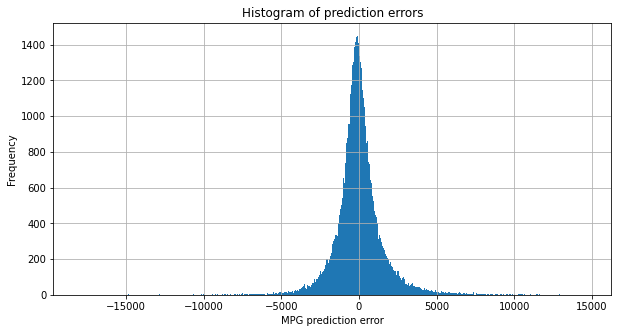

In [57]:
diff = y_test - predictions
plt.figure(figsize=(10,5))
diff.hist(bins = 500)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')



**В двумерном виде (прямая - это очень хорошо)**

In [58]:
dict_plot = {'true':y_test,
     'predicted':predictions}


plot_df = pd.DataFrame(data =dict_plot, columns = dict_plot.keys())

<AxesSubplot:xlabel='true', ylabel='predicted'>

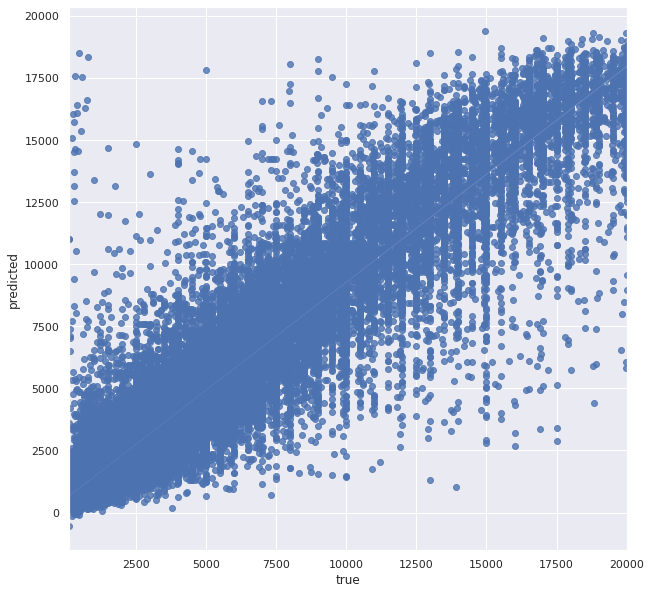

In [59]:
sns.set()

plt.figure(figsize=(10, 10))


sns.regplot(x='true', y= 'predicted', data = plot_df)


## <a id="summary">Выводы </a>

Мы предобработали параметры и составили пайплайны машинного обучения в двух вариантах:

* Обработка категориальных признаков с помощью

    * OrdinalEncoder (числовое кодирование)
    * OneHotEndoder (числовое бинарное кодирование)

* Для числовых признаков использовался StandardScaler

Далее для отобранных 10 признаков, мы протестировали модели Ridge регрессии, дерева решений, случайного леса, LightGBM, CatBoost.

Показатели на дефолтных параметрах:

- Ridge регрессия показала наихудший результат - 2751 rmse ,  и 4,5 сек обучения (OHE)

- DecisionTreeRegressor плохо себя показала - 2100 rmse, время обучения - почти 100 сек (OE)

- RandomForestRegressor отлично показал себя - 1650 rmse, время обучения - 20 сек (OE)

- CatBoost дал лучшую метрику - 1663 rmse, время обучения - 3 минуты

- LightGBM почти не отстал от предыдущего - 1678 rmse при всего лишь 40 секундах обучения

***Мы решили остановиться на модели градиентного бустинга от Microsoft - LightGBM***

После тюнинга гиперпараметров LightGBM показала:

- Время тюнинга - 575 c

- Время обучения - 16 с

- Время предсказания - 1 с

**Таким образом, мы получили лучшее значение метрики RMSE на уровне отклонения в 
RMSE: 1603 euro ,
MAE: 1009  
R2 - score 87,2% (способность улавливать изменение зависимой переменной от независимой)**

Именно эту модель мы бы хотели предложить использовать в дальнейшем при вводе в продакшн

[<center>В начало</center>](#start)</a>


